In [31]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error

In [13]:
# Display options for better readability, being a large dataset
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [14]:
# combine the csv files into one dataframe
data_path = 'data/*.csv'
files = glob.glob(data_path)

df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [29]:
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365CH,B365CD,B365CA,B365C>2.5,B365C<2.5,B365CAHH,B365CAHA
0,2020-09-18,Famalicao,Benfica,1,5,A,0,3,A,6,13,2,7,14,10,3,4,1,2,0,0,8.00,5.00,1.33,1.61,2.25,1.84,2.06
1,2020-09-18,Guimaraes,Belenenses,0,1,A,0,0,D,11,4,2,3,14,20,7,2,1,4,0,0,1.45,4.33,7.00,1.95,1.85,1.91,1.99
2,2020-09-19,Nacional,Boavista,3,3,D,2,2,D,14,8,7,3,24,21,6,4,4,3,0,0,2.55,3.10,2.87,2.50,1.50,1.84,2.06
3,2020-09-19,Porto,Sp Braga,3,1,H,2,1,H,11,7,4,1,17,18,5,1,0,0,0,0,1.61,4.00,5.00,1.72,2.07,1.89,2.01
4,2020-09-20,Santa Clara,Maritimo,2,0,H,0,0,D,12,12,5,2,15,17,5,6,2,1,0,0,2.37,3.00,3.20,2.70,1.44,2.08,1.82


In [28]:
df.info(verbose=True, show_counts=True) #using parameter verbose=True to show all columns and show_counts for their counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467 entries, 0 to 1466
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1467 non-null   datetime64[ns]
 1   HomeTeam   1467 non-null   string        
 2   AwayTeam   1467 non-null   string        
 3   FTHG       1467 non-null   int64         
 4   FTAG       1467 non-null   int64         
 5   FTR        1467 non-null   category      
 6   HTHG       1467 non-null   int64         
 7   HTAG       1467 non-null   int64         
 8   HTR        1467 non-null   category      
 9   HS         1467 non-null   int64         
 10  AS         1467 non-null   int64         
 11  HST        1467 non-null   int64         
 12  AST        1467 non-null   int64         
 13  HF         1467 non-null   int64         
 14  AF         1467 non-null   int64         
 15  HC         1467 non-null   int64         
 16  AC         1467 non-null   int64         


In [30]:
df.count()

Date         1467
HomeTeam     1467
AwayTeam     1467
FTHG         1467
FTAG         1467
FTR          1467
HTHG         1467
HTAG         1467
HTR          1467
HS           1467
AS           1467
HST          1467
AST          1467
HF           1467
AF           1467
HC           1467
AC           1467
HY           1467
AY           1467
HR           1467
AR           1467
B365CH       1467
B365CD       1467
B365CA       1467
B365C>2.5    1467
B365C<2.5    1467
B365CAHH     1467
B365CAHA     1467
dtype: int64

<Axes: >

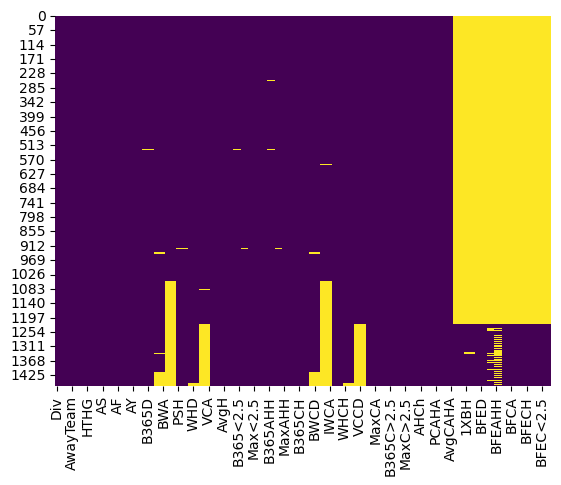

In [18]:
#Verify if there are any missing values
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [19]:
df.isnull().sum()

Div             0
Date            0
Time            0
HomeTeam        0
AwayTeam        0
FTHG            0
FTAG            0
FTR             0
HTHG            0
HTAG            0
HTR             0
HS              0
AS              0
HST             0
AST             0
HF              0
AF              0
HC              0
AC              0
HY              0
AY              0
HR              0
AR              0
B365H           2
B365D           2
B365A           2
BWH            69
BWD            69
BWA            69
IWH           415
IWD           415
IWA           415
PSH             2
PSD             2
PSA             2
WHH            11
WHD            11
WHA            11
VCH           245
VCD           245
VCA           245
MaxH            0
MaxD            0
MaxA            0
AvgH            0
AvgD            0
AvgA            0
B365>2.5        1
B365<2.5        1
P>2.5           2
P<2.5           2
Max>2.5         0
Max<2.5         0
Avg>2.5         0
Avg<2.5         0
AHh       

DATA CLEANING

In [20]:
# Drop non-essential columns
# remove time, not relevant for analysis
# remove div, same value for all
# remove recent betting houses, low data
# remove all betting odds but one, similar values (keep bet365)
# remove first betting odds, maintain only recent ones (represented with "c" after the name)

# resume: remove div, time and all betting odds but one (bet365c)


remove_columns = ['Div','Time']

df = df.drop(columns=remove_columns)

# drop columns with at least one NaN value
df = df.dropna(axis=1)


prefix_to_remove = ['Max','Avg','AH']

# remove columns with prefix "Max", "Avg" or "AH"
for prefix in prefix_to_remove:
    cols_to_drop = [col for col in df.columns if col.startswith(prefix)]
    df = df.drop(columns=cols_to_drop)


In [21]:
# Verify duplicated rows

duplicadas = df[df.duplicated()]
print(f"Duplicated rows: {len(duplicadas)}")
print("Duplicated by game (HomeTeam, AwayTeam, Date):", df.duplicated(subset=['HomeTeam', 'AwayTeam', 'Date']).sum())

Duplicated rows: 0
Duplicated by game (HomeTeam, AwayTeam, Date): 0


In [27]:
# Change data types
df['Date'] = pd.to_datetime(df['Date'],  dayfirst=True)

df[['HomeTeam', 'AwayTeam']] = df[['HomeTeam', 'AwayTeam']].astype('string')
df[['FTR', 'HTR']] = df[['FTR', 'HTR']].astype('category')

MODEL CREATION (CLASSIFICATION AND REGRESSION)

In [32]:
features = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365CH', 'B365CD', 'B365CA']

target_result = 'FTR'
target_home_goals = 'FTHG'
target_away_goals = 'FTAG'

In [46]:
train = df[df['Date'] < '2023-01-01']
test = df[df['Date'] >= '2023-01-01']

# Split the data into features and target variable
X_train = train[features]
y_train_result = train[target_result]
y_train_home_goals = train[target_home_goals]
y_train_away_goals = train[target_away_goals]

X_test = test[features]
y_test_result = test[target_result]
y_test_home_goals = test[target_home_goals]
y_test_away_goals = test[target_away_goals]

In [47]:
# Classification model for FTR
clf_result = RandomForestClassifier(random_state=42)
clf_result.fit(X_train, y_train_result)

# Regression model for FTHG and FTAG
reg_home_goals = RandomForestRegressor(random_state=42)
reg_home_goals.fit(X_train, y_train_home_goals)

reg_away_goals = RandomForestRegressor(random_state=42)
reg_away_goals.fit(X_train, y_train_away_goals)

RandomForestRegressor(random_state=42)

In [48]:
# Predictions

y_pred_result = clf_result.predict(X_test)

y_pred_home_goals = reg_home_goals.predict(X_test)
y_pred_away_goals = reg_away_goals.predict(X_test)

In [49]:
# Evaluation

print("Classification Report for FTR:")
print(classification_report(y_test_result, y_pred_result))
print("Confusion Matrix for FTR:")
print(confusion_matrix(y_test_result, y_pred_result))
print("Accuracy for FTR:", accuracy_score(y_test_result, y_pred_result))

print("Mean Absolute Error for FTHG:", mean_absolute_error(y_test_home_goals, y_pred_home_goals))
print("Mean Absolute Error for FTAG:", mean_absolute_error(y_test_away_goals, y_pred_away_goals))

Classification Report for FTR:
              precision    recall  f1-score   support

           A       0.63      0.72      0.67       221
           D       0.34      0.25      0.29       171
           H       0.70      0.72      0.71       338

    accuracy                           0.61       730
   macro avg       0.56      0.57      0.56       730
weighted avg       0.59      0.61      0.60       730

Confusion Matrix for FTR:
[[160  31  30]
 [ 54  43  74]
 [ 41  53 244]]
Accuracy for FTR: 0.6123287671232877
Mean Absolute Error for FTHG: 0.7711095890410958
Mean Absolute Error for FTAG: 0.7127945205479451
